# Imports classiques
Nous allons tout d'abord lancer les imports classiques

In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import Optim as opt
import functions as func

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
def contour_and_f_plot(res,function, levels=None,xmin=-2,xmax=2,ymin=-2,ymax=2):
    xiter=np.array(res['list_x'])
    fig, axarr = plt.subplots(2, 2, figsize=(16,8))
    # First plot 
    axarr[0,0].set_title('Points and levelset')
    Nx = 1000
    Ny = 1000
    x = np.linspace(xmin,xmax,Nx)
    y = np.linspace(ymin,ymax,Ny)
    X, Y = np.meshgrid(x, y)
    Z=function.value((X,Y))
    if levels:
        CS = axarr[0,0].contour(X, Y, Z, levels)
    else:
        CS = axarr[0,0].contour(X, Y, Z)
    axarr[0,0].plot(xiter[:,0], xiter[:,1],'+')
    axarr[0,0].clabel(CS, inline=1, fontsize=10)
    axarr[0,0].axis('equal')
    # Second plot
    axarr[0,1].set_title('Evolution of the cost')
    fiter=np.array(res['list_costs'])
    if min(fiter) > 0:
        axarr[0,1].semilogy(fiter)
    else:
        axarr[0,1].plot(fiter)
    #Third plot
    axarr[1,0].set_title('Norm of the gradient')
    giter=np.array(res['list_grads'])
    axarr[1,0].semilogy(giter)
    #Fourth plot
    axarr[1,1].set_title('Steps')
    siter=np.array(res['list_steps'])
    axarr[1,1].plot(siter)
    plt.show()


## L-BFGS
Nous allons nous intéresser à l'algorithme Limited Memory BFGS. Cet algorithme est du type BFGS, c'est à dire qu'il estime l'inverse de la Hessienne de $f$. Le L dans le nom de l'algorithme signifie qu'il est à mémoire limitée, c'est à dire qu'il ne garde en mémoire que les $L$ dernières itérations de calcul pour estimer la Hessienne.
L'algorithme est le suivant : Nous sommes à l'itération $k$, nous notons $x_k$ l'itéré et nous avons stocké les vecteurs suivants pour tout $k_{min}\le i\le k$.
$$ \sigma_i=x_{i}-x_{i-1} \text{ et } y_i=\nabla f(x_{i}) -\nabla f(x_{i-1})$$
Et on a aussi stocké $\rho_i=\frac{1}{(\sigma_i,y_i)}$. Tous les $\rho_i$ doivent être positifs.
L'algorithme est le suivant 

<div style="background-color:rgba(0, 0, 0, 0.0470588); padding:10px 0;font-family:monospace;">
$q=-\nabla f(x_k)$<br>
Pour $i=k,k-1,\dots k_{min}$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$\alpha_i=\rho_i(\sigma_i \cdot q)$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$q=q-\alpha_i y_i$<br>
$r=\displaystyle \frac{(\sigma_{k_{min}}\cdot y_{k_{min}})}{(y_{k_{min}}\cdot y_{k_{min}})}r$<br>
Pour $i=k_{min},k_{min}+1,\dots,k$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$\beta_i=\rho_i(y_i\cdot r)$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$q=q+(\alpha_i-\beta_i)\sigma_i$<br>
rend r
</div>



# Fonctions sur les listes
Vous aurez sans doute besoin des fonctions suivantes pour les listes

In [9]:
a=[(2*i,3*i) for i in range(5) ]
print(a)
print(a[3],a[-1])
print('*** Pop ***')
a.pop(0)
print(a)
print('*** Parcours ***')
for e,f in a :
      print(e,'et',f)
print('*** Parcours Inverse***')
for e in reversed(a) :
      print(e)
b=[e**2 for e,f in a]
print(b)
print('*** Parcours de deux listes ensembles***')
for (m,(t,p)) in zip(b,a) :
    print(m,'et',t,'et encore',p)
print('*** Append ***')
print(b)
b.append(546)
print(b)
print('*** Inversion ***')
c=list(reversed(b))
print(c)
print(len(b))

[(0, 0), (2, 3), (4, 6), (6, 9), (8, 12)]
(6, 9) (8, 12)
*** Pop ***
[(2, 3), (4, 6), (6, 9), (8, 12)]
*** Parcours ***
2 et 3
4 et 6
6 et 9
8 et 12
*** Parcours Inverse***
(8, 12)
(6, 9)
(4, 6)
(2, 3)
[4, 16, 36, 64]
*** Parcours de deux listes ensembles***
4 et 2 et encore 3
16 et 4 et encore 6
36 et 6 et encore 9
64 et 8 et encore 12
*** Append ***
[4, 16, 36, 64]
[4, 16, 36, 64, 546]
*** Inversion ***
[546, 64, 36, 16, 4]
5


# Class BFGS
Créez une classe `BFGS` dans `Optim.py`, sa fonction `__init__` sera de la forme 
`__init__(self,nb_stock_max=8)` où `nb_stock_max` est le nombre maximum d'itérations prises en compte. Cette fonction créera aussi une liste vide appelée `stock` qui conserve les $\sigma_i,y_i,\rho_i$. Elle devra aussi créer une liste vide nommée `last_iter`.


# Push
Nous allons maintenant créer une fonction `push(self, x, grad)` qui enregistre $\sigma_k,y_k,\rho_k$. Pour cela, on a besoin de $x_{k-1},\nabla f(x_{k-1})$. Si ils existent, ils se trouvent dans la liste `self.last_iter`. Ensuite on peut calculer $\sigma_k,y_k$ et $\rho_k$. 

Si $\rho_k$ est positif, alors on enregistre le triplet $(\sigma_k,y_k,\rho_k)$ à la fin de la liste `self.stock`, en vérifiant `self.stock` ne doit contenir au maximum que les dernières `self.nb_stock_max` itérations (si nécessaire on retire le tout premier élément de `self.stock`). 

Si $\rho_k$ est négatif, quelquechose c'est mal passé, on vide le `self.stock`.

A la fin, on n'oublie pas de mettre $x_{k}$ et $\nabla f(x_{k})$ dans `self.last_iter` pour être sûr de les y trouver la prochaine fois.

# Get

Nous allons maintenant créer une fonction `get(self, grad)` qui modifie la direction de descente et applique l'algorithme ci-dessus. Cette fonction doit nous rendre le `r` final. Si le `self.stock` est vide, cette fonction doit nous rendre `-grad`

# dc

Nous créeons maintenant une fonction `dc(self,x,function,df)` qui appplique tout d'abord `self.push` puis `self.get`, elle rend le résultat de la fonction de `self.get` et une variable d'info.

# C'est l'heure de tester ...
Lancez une méthode de Newton_Wolfe sur votre fonction préférée et à chaque itération calculez ce que donnerait un L-BFGS. Comparez les angles des directions entre la méthode de Newton et le L-BFGS, comparez aussi le ration des normes. Ensuite lancez un LBFGS avec recherche de pas de Wolfe sur vos tests préférez et obtenez le comportement de Newton_Wolfe sans le calcul de la Hessienne...


Fonction (x,y) --> 100*(y-x^2)^2+(1-x)^2
iter=   0 f=4.040e+02 df=8.980e+02 comp=[   1,   1,   0]
iter=   1 f=2.978e+01 df=1.644e+02 comp=[  40,  23,   1]
iter=   2 f=1.820e+01 df=2.100e+02 comp=[  67,  39,   2]
iter=   3 f=1.690e+01 df=2.930e+02 comp=[  94,  55,   3]
iter=   4 f=1.202e+00 df=6.045e+01 comp=[ 141,  81,   4]
iter=   5 f=3.920e-01 df=6.106e+00 comp=[ 188, 107,   5]
iter=   6 f=3.840e-01 df=8.433e-01 comp=[ 235, 133,   6]
iter=   7 f=3.839e-01 df=1.014e+00 comp=[ 278, 157,   7]
iter=   8 f=3.839e-01 df=1.233e+00 comp=[ 321, 181,   8]
iter=   9 f=3.835e-01 df=3.925e-01 comp=[ 368, 207,   9]
iter=  10 f=3.833e-01 df=1.200e+00 comp=[ 403, 227,  10]
iter=  11 f=3.829e-01 df=3.906e-01 comp=[ 450, 253,  11]
iter=  12 f=3.827e-01 df=1.163e+00 comp=[ 485, 273,  12]
iter=  13 f=3.824e-01 df=3.885e-01 comp=[ 532, 299,  13]
iter=  14 f=3.821e-01 df=1.122e+00 comp=[ 567, 319,  14]
iter=  15 f=3.818e-01 df=3.864e-01 comp=[ 614, 345,  15]
iter=  16 f=3.817e-01 df=2.182e+00 comp=[ 645, 

iter= 887 f=7.365e-02 df=4.646e-01 comp=[36438,20437, 887]
iter= 888 f=7.356e-02 df=2.767e-01 comp=[36481,20461, 888]
iter= 889 f=7.352e-02 df=4.197e-01 comp=[36520,20483, 889]
iter= 890 f=7.344e-02 df=2.610e-01 comp=[36563,20507, 890]
iter= 891 f=7.339e-02 df=3.809e-01 comp=[36602,20529, 891]
iter= 892 f=7.333e-02 df=2.480e-01 comp=[36645,20553, 892]
iter= 893 f=7.327e-02 df=3.475e-01 comp=[36684,20575, 893]
iter= 894 f=7.326e-02 df=5.814e-01 comp=[36723,20597, 894]
iter= 895 f=7.315e-02 df=3.188e-01 comp=[36766,20621, 895]
iter= 896 f=7.313e-02 df=5.175e-01 comp=[36805,20643, 896]
iter= 897 f=7.303e-02 df=2.947e-01 comp=[36848,20667, 897]
iter= 898 f=7.299e-02 df=4.622e-01 comp=[36887,20689, 898]
iter= 899 f=7.291e-02 df=2.747e-01 comp=[36930,20713, 899]
iter= 900 f=7.287e-02 df=4.147e-01 comp=[36969,20735, 900]
iter= 901 f=7.279e-02 df=2.582e-01 comp=[37012,20759, 901]
iter= 902 f=7.274e-02 df=3.741e-01 comp=[37051,20781, 902]
iter= 903 f=7.268e-02 df=2.448e-01 comp=[37094,20805, 90

iter=1875 f=2.536e-02 df=1.545e-01 comp=[76034,42705,1875]
iter=1876 f=2.535e-02 df=3.772e-01 comp=[76069,42725,1876]
iter=1877 f=2.529e-02 df=1.533e-01 comp=[76112,42749,1877]
iter=1878 f=2.527e-02 df=3.701e-01 comp=[76147,42769,1878]
iter=1879 f=2.521e-02 df=1.520e-01 comp=[76190,42793,1879]
iter=1880 f=2.519e-02 df=3.624e-01 comp=[76225,42813,1880]
iter=1881 f=2.513e-02 df=1.507e-01 comp=[76268,42837,1881]
iter=1882 f=2.511e-02 df=3.543e-01 comp=[76303,42857,1882]
iter=1883 f=2.505e-02 df=1.493e-01 comp=[76346,42881,1883]
iter=1884 f=2.503e-02 df=3.457e-01 comp=[76381,42901,1884]
iter=1885 f=2.498e-02 df=1.479e-01 comp=[76424,42925,1885]
iter=1886 f=2.495e-02 df=3.367e-01 comp=[76459,42945,1886]
iter=1887 f=2.490e-02 df=1.464e-01 comp=[76502,42969,1887]
iter=1888 f=2.487e-02 df=3.274e-01 comp=[76537,42989,1888]
iter=1889 f=2.483e-02 df=1.450e-01 comp=[76580,43013,1889]
iter=1890 f=2.480e-02 df=3.179e-01 comp=[76615,43033,1890]
iter=1891 f=2.475e-02 df=1.435e-01 comp=[76658,43057,189

iter=2920 f=1.186e-03 df=3.066e-02 comp=[115469,65035,2920]
iter=2921 f=1.179e-03 df=2.111e-01 comp=[115492,65049,2921]
iter=2922 f=1.157e-03 df=3.036e-02 comp=[115535,65073,2922]
iter=2923 f=1.152e-03 df=2.185e-01 comp=[115558,65087,2923]
iter=2924 f=1.129e-03 df=3.004e-02 comp=[115601,65111,2924]
iter=2925 f=1.126e-03 df=2.215e-01 comp=[115624,65125,2925]
iter=2926 f=1.102e-03 df=2.969e-02 comp=[115667,65149,2926]
iter=2927 f=1.099e-03 df=2.198e-01 comp=[115690,65163,2927]
iter=2928 f=1.075e-03 df=2.931e-02 comp=[115733,65187,2928]
iter=2929 f=1.071e-03 df=2.135e-01 comp=[115756,65201,2929]
iter=2930 f=1.049e-03 df=2.891e-02 comp=[115799,65225,2930]
iter=2931 f=1.044e-03 df=2.028e-01 comp=[115822,65239,2931]
iter=2932 f=1.024e-03 df=2.848e-02 comp=[115865,65263,2932]
iter=2933 f=1.016e-03 df=1.885e-01 comp=[115888,65277,2933]
iter=2934 f=9.988e-04 df=2.805e-02 comp=[115931,65301,2934]
iter=2935 f=9.888e-04 df=1.713e-01 comp=[115954,65315,2935]
iter=2936 f=9.745e-04 df=2.762e-02 comp=

iter=3923 f=4.026e-05 df=1.373e-02 comp=[154066,86841,3923]
iter=3924 f=4.020e-05 df=1.345e-02 comp=[154105,86863,3924]
iter=3925 f=4.013e-05 df=1.319e-02 comp=[154144,86885,3925]
iter=3926 f=4.007e-05 df=1.293e-02 comp=[154183,86907,3926]
iter=3927 f=4.000e-05 df=1.267e-02 comp=[154222,86929,3927]
iter=3928 f=3.994e-05 df=1.243e-02 comp=[154261,86951,3928]
iter=3929 f=3.987e-05 df=1.219e-02 comp=[154300,86973,3929]
iter=3930 f=3.981e-05 df=1.196e-02 comp=[154339,86995,3930]
iter=3931 f=3.974e-05 df=1.173e-02 comp=[154378,87017,3931]
iter=3932 f=3.968e-05 df=1.151e-02 comp=[154417,87039,3932]
iter=3933 f=3.962e-05 df=1.130e-02 comp=[154456,87061,3933]
iter=3934 f=3.955e-05 df=1.109e-02 comp=[154495,87083,3934]
iter=3935 f=3.949e-05 df=1.089e-02 comp=[154534,87105,3935]
iter=3936 f=3.943e-05 df=1.070e-02 comp=[154573,87127,3936]
iter=3937 f=3.936e-05 df=1.051e-02 comp=[154612,87149,3937]
iter=3938 f=3.930e-05 df=1.032e-02 comp=[154651,87171,3938]
iter=3939 f=3.924e-05 df=1.015e-02 comp=

iter=4902 f=8.477e-06 df=5.508e-03 comp=[192143,108327,4902]
iter=4903 f=8.463e-06 df=5.359e-03 comp=[192182,108349,4903]
iter=4904 f=8.449e-06 df=5.217e-03 comp=[192221,108371,4904]
iter=4905 f=8.436e-06 df=5.080e-03 comp=[192260,108393,4905]
iter=4906 f=8.422e-06 df=4.949e-03 comp=[192299,108415,4906]
iter=4907 f=8.408e-06 df=4.824e-03 comp=[192338,108437,4907]
iter=4908 f=8.395e-06 df=4.704e-03 comp=[192377,108459,4908]
iter=4909 f=8.381e-06 df=4.589e-03 comp=[192416,108481,4909]
iter=4910 f=8.368e-06 df=4.480e-03 comp=[192455,108503,4910]
iter=4911 f=8.354e-06 df=4.375e-03 comp=[192494,108525,4911]
iter=4912 f=8.341e-06 df=4.276e-03 comp=[192533,108547,4912]
iter=4913 f=8.327e-06 df=4.180e-03 comp=[192572,108569,4913]
iter=4914 f=8.314e-06 df=4.089e-03 comp=[192611,108591,4914]
iter=4915 f=8.301e-06 df=4.003e-03 comp=[192650,108613,4915]
iter=4916 f=8.288e-06 df=3.920e-03 comp=[192689,108635,4916]
iter=4917 f=8.275e-06 df=3.842e-03 comp=[192728,108657,4917]
iter=4918 f=8.261e-06 df

iter=5925 f=1.636e-06 df=1.690e-03 comp=[231904,130765,5925]
iter=5926 f=1.633e-06 df=1.653e-03 comp=[231943,130787,5926]
iter=5927 f=1.631e-06 df=1.619e-03 comp=[231982,130809,5927]
iter=5928 f=1.630e-06 df=3.544e-03 comp=[232017,130829,5928]
iter=5929 f=1.627e-06 df=3.418e-03 comp=[232056,130851,5929]
iter=5930 f=1.625e-06 df=3.297e-03 comp=[232095,130873,5930]
iter=5931 f=1.622e-06 df=3.181e-03 comp=[232134,130895,5931]
iter=5932 f=1.619e-06 df=3.071e-03 comp=[232173,130917,5932]
iter=5933 f=1.616e-06 df=2.965e-03 comp=[232212,130939,5933]
iter=5934 f=1.613e-06 df=2.865e-03 comp=[232251,130961,5934]
iter=5935 f=1.610e-06 df=2.768e-03 comp=[232290,130983,5935]
iter=5936 f=1.608e-06 df=2.677e-03 comp=[232329,131005,5936]
iter=5937 f=1.605e-06 df=2.589e-03 comp=[232368,131027,5937]
iter=5938 f=1.602e-06 df=2.506e-03 comp=[232407,131049,5938]
iter=5939 f=1.599e-06 df=2.426e-03 comp=[232446,131071,5939]
iter=5940 f=1.597e-06 df=2.350e-03 comp=[232485,131093,5940]
iter=5941 f=1.594e-06 df

iter=6942 f=3.162e-07 df=1.036e-03 comp=[271415,153063,6942]
iter=6943 f=3.157e-07 df=1.003e-03 comp=[271454,153085,6943]
iter=6944 f=3.152e-07 df=9.711e-04 comp=[271493,153107,6944]
iter=6945 f=3.147e-07 df=9.412e-04 comp=[271532,153129,6945]
iter=6946 f=3.141e-07 df=9.128e-04 comp=[271571,153151,6946]
iter=6947 f=3.136e-07 df=8.859e-04 comp=[271610,153173,6947]
iter=6948 f=3.131e-07 df=8.605e-04 comp=[271649,153195,6948]
iter=6949 f=3.126e-07 df=8.365e-04 comp=[271688,153217,6949]
iter=6950 f=3.121e-07 df=8.138e-04 comp=[271727,153239,6950]
iter=6951 f=3.116e-07 df=7.924e-04 comp=[271766,153261,6951]
iter=6952 f=3.111e-07 df=7.722e-04 comp=[271805,153283,6952]
iter=6953 f=3.106e-07 df=7.532e-04 comp=[271844,153305,6953]
iter=6954 f=3.101e-07 df=7.353e-04 comp=[271883,153327,6954]
iter=6955 f=3.096e-07 df=7.184e-04 comp=[271922,153349,6955]
iter=6956 f=3.091e-07 df=7.026e-04 comp=[271961,153371,6956]
iter=6957 f=3.091e-07 df=1.532e-03 comp=[271996,153391,6957]
iter=6958 f=3.085e-07 df

iter=7962 f=6.061e-08 df=4.177e-04 comp=[311039,175425,7962]
iter=7963 f=6.051e-08 df=4.047e-04 comp=[311078,175447,7963]
iter=7964 f=6.041e-08 df=3.924e-04 comp=[311117,175469,7964]
iter=7965 f=6.031e-08 df=3.808e-04 comp=[311156,175491,7965]
iter=7966 f=6.022e-08 df=3.699e-04 comp=[311195,175513,7966]
iter=7967 f=6.012e-08 df=3.595e-04 comp=[311234,175535,7967]
iter=7968 f=6.002e-08 df=3.498e-04 comp=[311273,175557,7968]
iter=7969 f=5.992e-08 df=3.406e-04 comp=[311312,175579,7969]
iter=7970 f=5.983e-08 df=3.320e-04 comp=[311351,175601,7970]
iter=7971 f=5.973e-08 df=3.238e-04 comp=[311390,175623,7971]
iter=7972 f=5.964e-08 df=3.162e-04 comp=[311429,175645,7972]
iter=7973 f=5.954e-08 df=3.090e-04 comp=[311468,175667,7973]
iter=7974 f=5.954e-08 df=6.744e-04 comp=[311503,175687,7974]
iter=7975 f=5.943e-08 df=6.484e-04 comp=[311542,175709,7975]
iter=7976 f=5.932e-08 df=6.237e-04 comp=[311581,175731,7976]
iter=7977 f=5.921e-08 df=6.002e-04 comp=[311620,175753,7977]
iter=7978 f=5.911e-08 df

iter=8976 f=1.173e-08 df=2.896e-04 comp=[350425,197653,8976]
iter=8977 f=1.171e-08 df=2.784e-04 comp=[350464,197675,8977]
iter=8978 f=1.169e-08 df=2.678e-04 comp=[350503,197697,8978]
iter=8979 f=1.167e-08 df=2.577e-04 comp=[350542,197719,8979]
iter=8980 f=1.165e-08 df=2.480e-04 comp=[350581,197741,8980]
iter=8981 f=1.163e-08 df=2.389e-04 comp=[350620,197763,8981]
iter=8982 f=1.161e-08 df=2.302e-04 comp=[350659,197785,8982]
iter=8983 f=1.159e-08 df=2.220e-04 comp=[350698,197807,8983]
iter=8984 f=1.157e-08 df=2.141e-04 comp=[350737,197829,8984]
iter=8985 f=1.155e-08 df=2.067e-04 comp=[350776,197851,8985]
iter=8986 f=1.153e-08 df=1.997e-04 comp=[350815,197873,8986]
iter=8987 f=1.151e-08 df=1.930e-04 comp=[350854,197895,8987]
iter=8988 f=1.149e-08 df=1.867e-04 comp=[350893,197917,8988]
iter=8989 f=1.147e-08 df=1.807e-04 comp=[350932,197939,8989]
iter=8990 f=1.145e-08 df=1.750e-04 comp=[350971,197961,8990]
iter=8991 f=1.143e-08 df=1.697e-04 comp=[351010,197983,8991]
iter=8992 f=1.141e-08 df

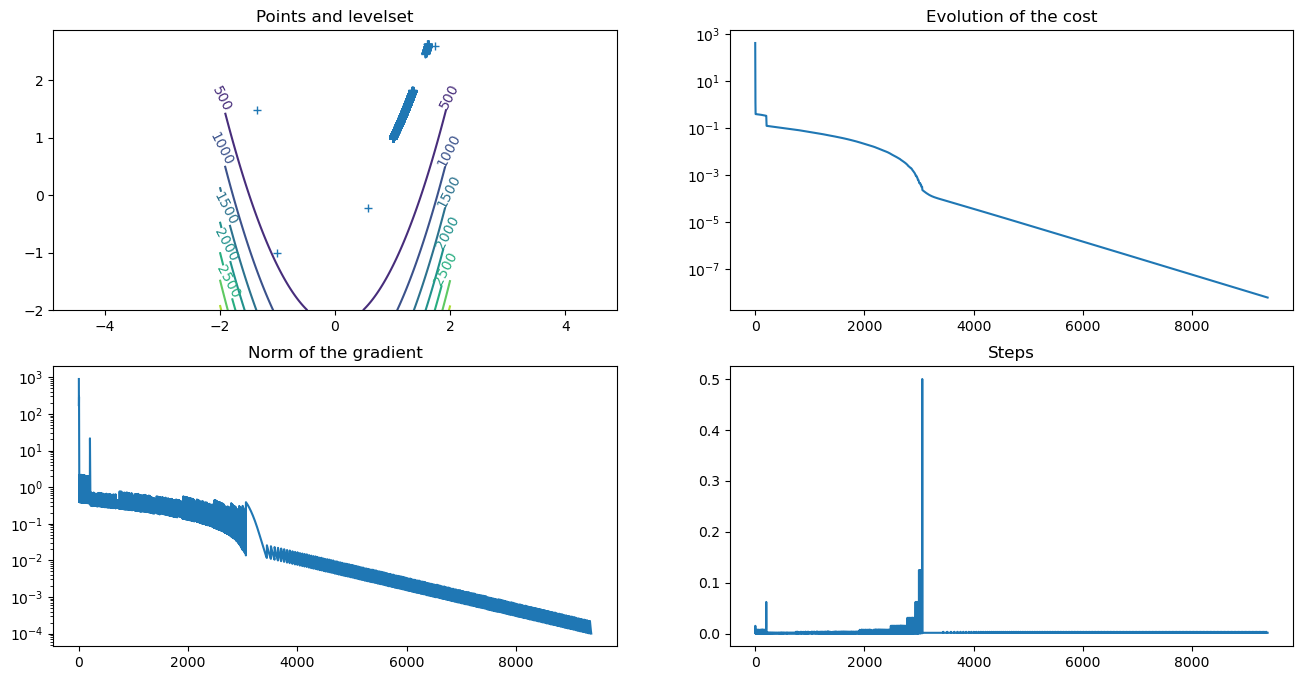

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, Non

In [10]:
f=func.Rosen()
x0=np.array([-1,-1])
res=opt.main_algorithm(f,0.1,x0,ls=opt.ls_wolfe_step_is_one,dc=opt.dc_newton,verbose=True)
contour_and_f_plot(res,f)
print(res['dc'])

Fonction (x,y) --> 100*(y-x^2)^2+(1-x)^2
iter=   0 f=4.040e+02 df=8.980e+02 comp=[   1,   1,   0]
iter=   1 f=2.978e+01 df=1.644e+02 comp=[  40,  23,   0]
iter=   2 f=3.519e+00 df=4.437e+01 comp=[  43,  27,   0]
iter=   3 f=6.637e-01 df=1.092e+01 comp=[  46,  31,   0]
iter=   4 f=4.552e-01 df=1.283e+00 comp=[  49,  35,   0]
iter=   5 f=4.516e-01 df=1.143e+00 comp=[  52,  39,   0]
iter=   6 f=4.458e-01 df=1.518e+00 comp=[  55,  43,   0]
iter=   7 f=4.275e-01 df=2.754e+00 comp=[  58,  47,   0]
iter=   8 f=1.789e-01 df=4.143e+00 comp=[  69,  63,   0]
iter=   9 f=1.755e-01 df=1.807e+00 comp=[  76,  69,   0]
iter=  10 f=1.544e-01 df=1.947e+00 comp=[  79,  73,   0]
iter=  11 f=1.221e-01 df=8.741e+00 comp=[  82,  77,   0]
iter=  12 f=7.946e-02 df=4.870e-01 comp=[  85,  81,   0]
iter=  13 f=5.721e-02 df=4.853e-01 comp=[  88,  85,   0]
iter=  14 f=4.109e-02 df=5.129e+00 comp=[  95,  91,   0]
iter=  15 f=2.735e-02 df=1.166e+00 comp=[  98,  95,   0]
iter=  16 f=1.570e-02 df=4.802e-01 comp=[ 101, 

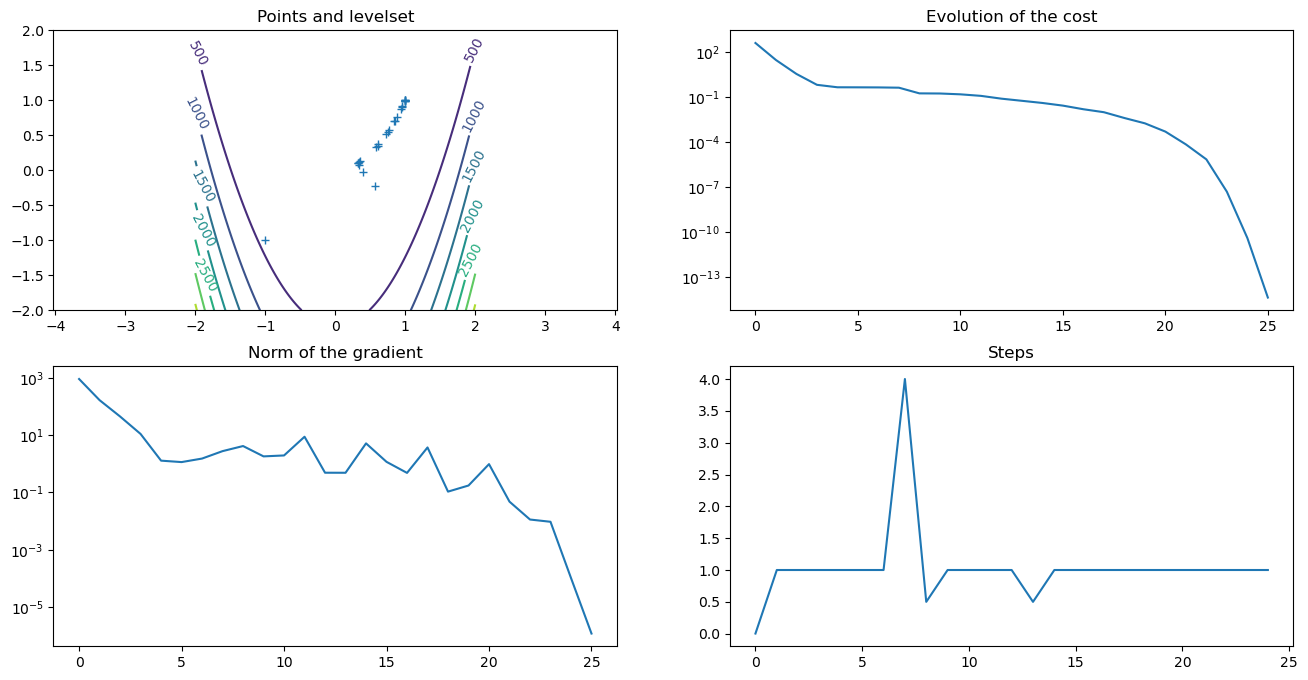

In [11]:
f=func.Rosen()
opt1=opt.BFGS(nb_stock_max=12)
x0=np.array([-1,-1])
res=opt.main_algorithm(f,0.1,x0,ls=opt.ls_wolfe_step_is_one,dc=opt1.dc,verbose=True)
contour_and_f_plot(res,f)